# Wild Card Project: Solar Radiation Prediction

In [2]:
!source .venv/bin/activate && python3 -m pip install --upgrade pip && python3 -m pip install -r requirements.txt

In [3]:
# Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from datetime import datetime, timedelta
import pytz
from pyproj import Proj, transform, Transformer
from pandas import Timestamp

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
WORKDIR = '/mnt/shared_disk/data'
# NSRDB data file
nsrdb_main = f'{WORKDIR}/nsrdb/nsrdb_conus_irradiance_2022.h5'
nsrdb = f'./nsrdb/nsrdb_conus_irradiance_20220722.h5'
nsrdb_resampled_path = f'./nsrdb/resampled/'
if not os.path.exists(nsrdb_resampled_path):
    os.makedirs(nsrdb_resampled_path)

# Wyoming data file
target_date = '2022-07-22'
wy_extent = [-111.1, -104.1, 41.0, 45.0]
target_state = 'Wyoming'
wyoming_time_zone = pytz.timezone("America/Denver")
compact_date = target_date.replace('-', '')

# GOES 16 data file
GOES = f'{WORKDIR}/goes16/'
goes_file_path = os.path.abspath(f'./goes16/{compact_date}/')
goes_16_coordinations = os.path.abspath(f'./goes16/coordinations/')
goes_16_lons_path = os.path.join(goes_16_coordinations, f'g16_lons_2km.txt')
goes_16_lats_path = os.path.join(goes_16_coordinations, f'g16_lats_2km.txt')
goes_16_figures = os.path.abspath(f'./goes16/figures/')
if not os.path.exists(goes_16_figures):
    os.makedirs(goes_16_figures)
goes_16_filtered_data_path = os.path.abspath(f'./goes16/filtered/')
if not os.path.exists(goes_16_filtered_data_path):
    os.makedirs(goes_16_filtered_data_path)    

# NSRDB and GOES 16 data
nsrdb_goes_16 = f'./nsrdb_goes_16/'
if not os.path.exists(nsrdb_goes_16):
    os.makedirs(nsrdb_goes_16)


In [ ]:
# Copy the files from the shared disk to the local disk
!mkdir -p ./goes/{date} && cd {date} && cp {GOES}/{date}/* ./

In [ ]:
def filter_datasets(hdf_file_path, output_file_path, target_date, target_state):
    with h5py.File(hdf_file_path, 'r') as hdf:

        # Load 'time_index' as strings and convert to datetime objects
        time_index_str = hdf['time_index'][:]
        time_index_str = np.array([ti.decode('utf-8') for ti in time_index_str])
        time_index_datetime = pd.to_datetime(time_index_str)
        

        # Create a mask for the target date
        date_mask = np.array([ti.date() == pd.Timestamp(target_date).date() for ti in time_index_datetime])

        # Load state metadata and create a mask for the target state
        states = np.array([state.decode('utf-8') for state in hdf['meta']['state'][:]])
        state_mask = states == target_state

        # Filter GHI data: select all date-masked rows and the column for the target state
        state_index = np.where(state_mask)[0]  # Get the index of the target state
        if state_index.size == 0:
            raise ValueError(f"No data found for state {target_state}")

        filtered_ghi = hdf['ghi'][date_mask, :][:, state_index]

        filtered_time_index = time_index_datetime[date_mask]

        meta = hdf['meta']
        metadata_fields = ['country', 'state', 'county', 'latitude', 'longitude', 'elevation', 'timezone', 'gid_full']
        metadata_fields_str = ['state', 'county', 'country']

        metadata = {}
        for field in metadata_fields:
            if field in metadata_fields_str:
                metadata[field] = [s.decode('utf-8') for s in meta[field][state_index]]
            else:
                metadata[field] = meta[field][state_index]

        df_meta = pd.DataFrame(metadata)
        df_meta.to_csv(f'./nsrdb/meta_{target_state}_{target_date}.csv', index=False)


        df_tmi = pd.DataFrame(filtered_time_index)
        df_tmi.to_csv(f'./nsrdb/fti_{target_state}_{target_date}.csv', index=False, header=False)


        df_ghi = pd.DataFrame(filtered_ghi)
        df_ghi.to_csv(f'./nsrdb/ghi_{target_state}_{target_date}.csv', index=False)        


        print("Data filtered and saved to", output_file_path)

# Example usage
filter_datasets(nsrdb_main, nsrdb, target_date, target_state)


In [ ]:
df_ghi = pd.read_csv(f'./nsrdb/ghi_{target_state}_{target_date}.csv')
location = pd.read_csv(f'./nsrdb/meta_{target_state}_{target_date}.csv')
time_index = pd.read_csv(f'./nsrdb/fti_{target_state}_{target_date}.csv', header=None)

In [8]:
def combine_data(index):
    ti = pd.Timestamp(time_index.iloc[i][0])
    ghi = pd.DataFrame(df_ghi.iloc[i])
    ghi.columns = ['ghi']
    ghi['time_index'] = ti
    df_combined = pd.concat([location.reset_index(drop=True), ghi.reset_index(drop=True)], axis=1)
    df_combined.to_csv(f'./nsrdb/combined_{target_state}_{target_date}_{ti}.csv', mode='a', header=False, index=False)
    return df_combined, ti

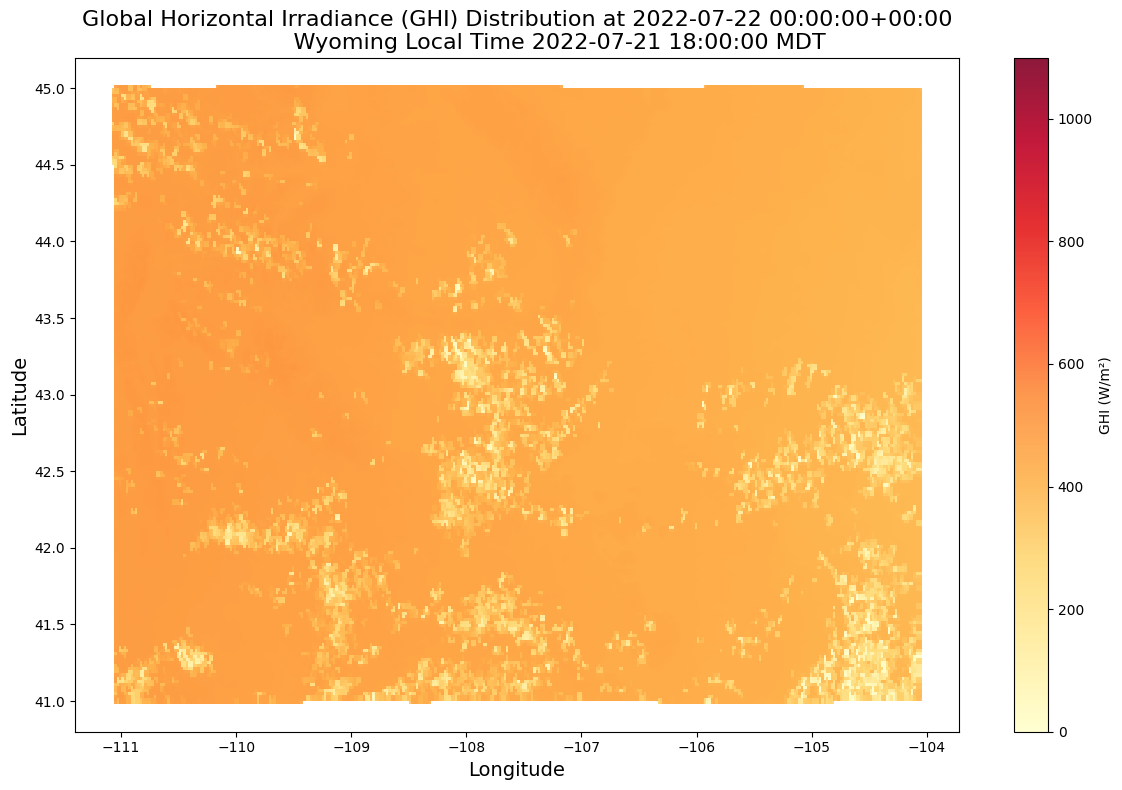

In [9]:
for i in range(len(time_index)):
    combined_data, date_time = combine_data(i)
    plt.figure(figsize=(12, 8))
    colors = plt.get_cmap('YlOrRd')
    sc = plt.scatter(
        combined_data["longitude"],
        combined_data["latitude"],
        c=combined_data["ghi"],
        cmap=colors,
        alpha=0.9,
        marker='s',
        s=20,
        edgecolor="none",
        vmin=0,
        vmax=1100
    )
    wyoming_time = date_time.astimezone(wyoming_time_zone)
    formatted_time = wyoming_time.strftime("%Y-%m-%d %H:%M:%S %Z")


    plt.colorbar(sc, label="GHI (W/m²)")
    plt.title(
        f"""Global Horizontal Irradiance (GHI) Distribution at {date_time}
            Wyoming Local Time {formatted_time}""",
        fontsize=16,
    )
    plt.xlabel("Longitude", fontsize=14)
    plt.ylabel("Latitude", fontsize=14)
    plt.tight_layout()
    plt.savefig('wyo.png')
    plt.show()


In [11]:
# ls directory in python
def goes16_files(goes_file_path):
    files = []
    for file in os.listdir(goes_file_path):
        if file.endswith(".nc"):
            files.append(os.path.join(goes_file_path, file))
    # sort the files
    files = sorted(files)
    return files

goes16_file_list = goes16_files(goes_file_path)

In [12]:
# https://www.star.nesdis.noaa.gov/atmospheric-composition-training/python_abi_lat_lon.php
#  Calculate latitude and longitude from GOES ABI fixed grid projection data
# GOES ABI fixed grid projection is a map projection relative to the GOES satellite
# Units: latitude in °N (°S < 0), longitude in °E (°W < 0)
# See GOES-R Product User Guide (PUG) Volume 5 (L2 products) Section 4.2.8 for details & example of calculations
# "file_id" is an ABI L1b or L2 .nc file opened using the netCDF4 library

def calculate_degrees(dataset):
    
    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = dataset.x # E/W scanning angle in radians
    y_coordinate_1d = dataset.y  # N/S elevation angle in radians
    projection_info = dataset.goes_imager_projection
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height + projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis
    
    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)
    
    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0  
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)
    
    # Ignore numpy errors for sqrt of negative number; occurs for GOES-16 ABI CONUS sector data
    np.seterr(all='ignore')
    
    abi_lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    abi_lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    
    lats_array = np.array(abi_lat)
    lons_array = np.array(abi_lon)
    
    mask = np.isnan(lats_array) | np.isnan(lons_array)
    lats_array[mask] = -9999
    lons_array[mask] = -9999

    # check for inf and nan in array
    if np.any(np.isnan(lats_array)) or np.any(np.isnan(lons_array)):
        print("NaN values found in longitude or latitude")
    if np.any(np.isinf(lats_array)) or np.any(np.isinf(lons_array)):
        print("Infinite values found in longitude or latitude")

    np.savetxt(goes_16_lats_path, lats_array)
    np.savetxt(goes_16_lons_path, lons_array)

    return abi_lat, abi_lon

In [ ]:
for file in goes16_file_list:
    with xr.open_dataset(file) as ds:
        latitude, longitude = calculate_degrees(ds)

In [207]:
r = ds.CMI_C02.data; r = np.clip(r, 0, 1)
g = ds.CMI_C03.data; g = np.clip(g, 0, 1)
b = ds.CMI_C01.data; b = np.clip(b, 0, 1)

In [208]:
# Plot the RGB image
gamma = 2.5; r = np.power(r, 1/gamma); g = np.power(g, 1/gamma); b = np.power(b, 1/gamma)
g_true = 0.45 * r + 0.1 * g + 0.45 * b
g_true = np.clip(g_true, 0, 1)
rgb = np.dstack((r, g_true, b))

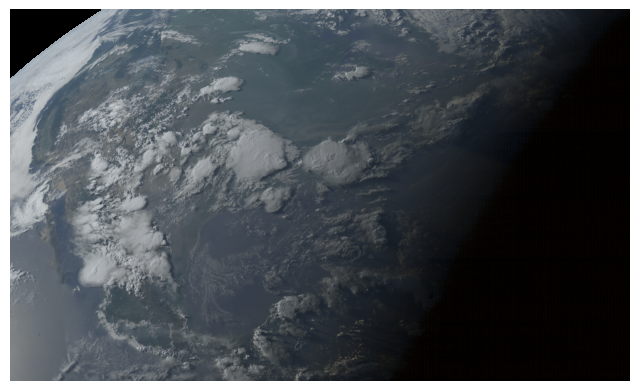

In [209]:
fig = plt.figure(figsize=(8,5))
plt.imshow(rgb)
plt.axis('off')
plt.show()

In [ ]:
with xr.open_dataset(goes16_file_list[0]) as ds:
    # Desired visualization extent [min_lon, max_lon, min_lat, max_lat]
    min_lon, max_lon, min_lat, max_lat = -111.1, -104.1, 41.0, 45.0

    extent = [min_lon, min_lat, max_lon, max_lat]
    lons = np.loadtxt(goes_16_lons_path)
    lats = np.loadtxt(goes_16_lats_path)

    ref_grid_resolution_km = 2

    # Get the image resolution
    band_resolution_km = ds.spatial_resolution
    band_resolution_km = float(band_resolution_km[:band_resolution_km.find("km")])
    
    # Calculate the lat lon pairs indexes for the desired extent
    idx_pair_1 = abs(lats - extent[1]) + abs(lons - extent[0])
    max_lat_idx,min_lon_idx = np.unravel_index(idx_pair_1.argmin(),idx_pair_1.shape)
    idx_pair_2 = abs(lats-extent[3])+abs(lons-extent[2])
    min_lat_idx,max_lon_idx = np.unravel_index(idx_pair_2.argmin(),idx_pair_2.shape)
    

    # The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
    sat_h = ds.goes_imager_projection.perspective_point_height
    x = ds.x[min_lon_idx:max_lon_idx] * sat_h
    y = ds.y[min_lat_idx:max_lat_idx] * sat_h

    data = ds.CMI_C02.data[min_lat_idx:max_lat_idx, min_lon_idx:max_lon_idx]

    # Choose the plot size (width x height, in inches)
    plt.figure(figsize=(12,12), dpi=300)
    # Use the Geostationary projection in cartopy
    ax = plt.axes(projection=ccrs.Geostationary(central_longitude=-75.0, satellite_height=35786023.0))
    img_extent = (x.min(), x.max(), y.min(), y.max())


    # Add coastlines, borders and gridlines
    ax.coastlines(resolution='10m', color='white', linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.7)
    ax.add_feature(cfeature.STATES, edgecolor='gold', linewidth=0.3)
    ax.add_feature(cfeature.RIVERS, edgecolor='blue', linewidth=0.3)
    ax.gridlines(color='white', alpha=0.5, linestyle='--', linewidth=0.5)
    
    # Inserting City Labels
    city_lons = [-105.3527]
    city_lats = [41.1839]
    labels = ['Larame']
    x_offsets = [0.1]
    y_offsets = [0]
    
    ax.plot(city_lons, city_lats, 'bo', color='cyan', markersize=5, transform=ccrs.Geodetic())
    
    for label, xpt, ypt, x_offset, y_offset in zip(labels, city_lons, city_lats, x_offsets, y_offsets):
        ax.text(xpt+x_offset , ypt+y_offset, label, fontsize=12, fontweight='bold', zorder=8, color='gold', transform=ccrs.Geodetic())
    
    # Plot the image
    img = ax.imshow(data, vmin=0.0, vmax=0.7, extent=img_extent, origin='upper', cmap='gray')
    
    # Getting the file date
    format_string = '%Y-%m-%dT%H:%M:%S'    
    date = str(datetime.strptime(str(ds.time_bounds[0].data)[:19], format_string))
    
    # Add a title
    plt.title('GOES-16 Band 02', fontweight='bold', fontsize=10, loc='left')
    plt.title('Sub Region \n' + date, fontsize=10, loc='right')
    
    # Save the image
    plt.savefig(goes_16_figures + 'goes16_band02.png', bbox_inches='tight', dpi=300)
    
    # Show the image
    plt.show()  

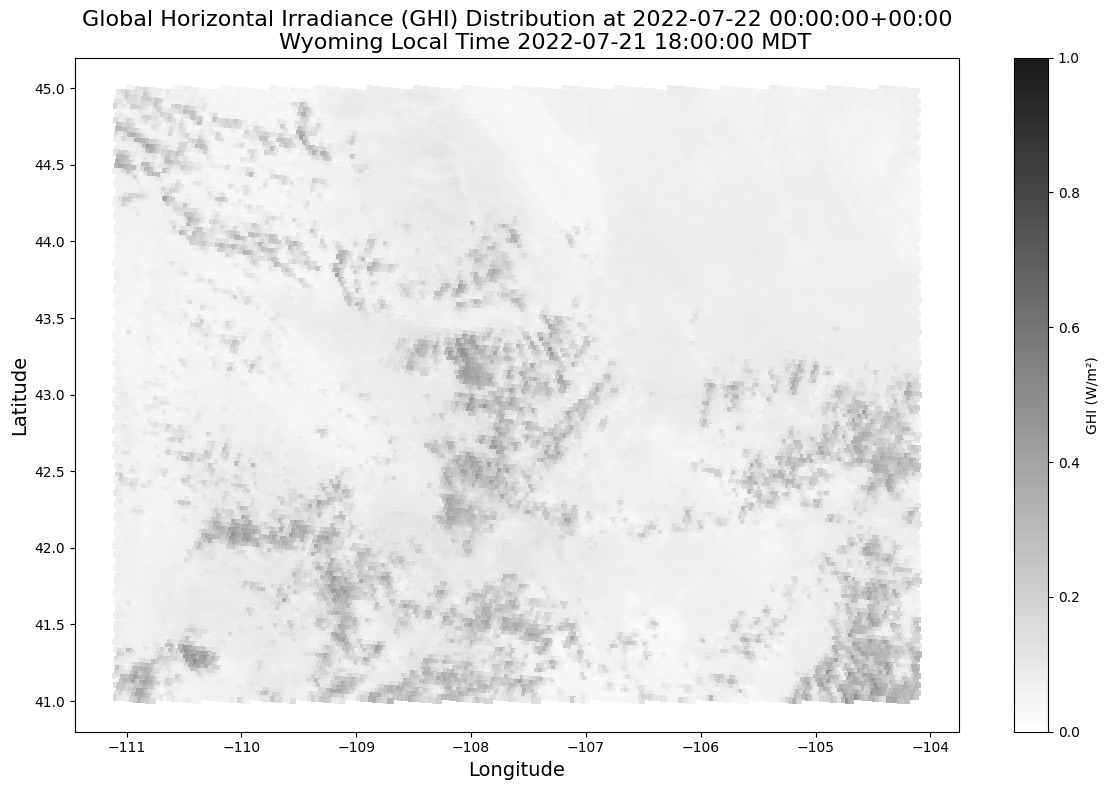

In [ ]:
# Open the dataset
ds = xr.open_dataset(goes16_file_list[0])

# Load longitude and latitude from pre-calculated files or calculate them
lons = np.loadtxt(goes_16_lons_path)
lats = np.loadtxt(goes_16_lats_path)

# Define Wyoming's geographic extent
wy_extent = [-111.1, -104.1, 41.0, 45.0]

# Find the indices within the Wyoming extent
lon_mask = (lons >= wy_extent[0]) & (lons <= wy_extent[1])
lat_mask = (lats >= wy_extent[2]) & (lats <= wy_extent[3])

# Assuming `lon_mask` and `lat_mask` are 2D boolean arrays with the same shape as `ds.CMI_C02`
data = np.array(ds.CMI_C02.data)
mask = lon_mask & lat_mask
data_filtered = data[mask]
wy_data = data_filtered

data_filtered = data[lon_mask & lat_mask]
lons_filtered = lons[lon_mask & lat_mask]   
lats_filtered = lats[lon_mask & lat_mask]
plt.figure(figsize=(12, 8))
colors = plt.get_cmap('gray_r')
sc = plt.scatter(
    lons_filtered,
    lats_filtered,
    c=data_filtered,
    cmap=colors,
    alpha=0.9,
    marker='s',
    s=20,
    edgecolor="none",
    vmin=0,
    vmax=1
)

date_time = pd.Timestamp(str(ds.time_bounds[0].data)[:19])
date_time = date_time.round('H').tz_localize('UTC')


wyoming_time = date_time.astimezone(wyoming_time_zone)
formatted_time = wyoming_time.strftime("%Y-%m-%d %H:%M:%S %Z")


plt.colorbar(sc, label="GHI (W/m²)")
plt.title(
    f"""Global Horizontal Irradiance (GHI) Distribution at {date_time}
        Wyoming Local Time {formatted_time}""",
    fontsize=16,
)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.tight_layout()
plt.savefig('wyo.png')
plt.show()


In [212]:
# Open the dataset and get file paths and each file index
lons = np.loadtxt(goes_16_lons_path)
lats = np.loadtxt(goes_16_lats_path)
for file_index, file_path  in enumerate(goes16_file_list):
    print(f"Processing file {file_index + 1} of {len(goes16_file_list)}")
    ds = xr.open_dataset(file_path)
    lon_mask = (lons >= wy_extent[0]) & (lons <= wy_extent[1])
    lat_mask = (lats >= wy_extent[2]) & (lats <= wy_extent[3])
    mask = lon_mask & lat_mask
    lons_filtered = lons[mask]   
    lats_filtered = lats[mask]
    
    bands_data = {}
    bands_data['longitude'] = lons_filtered
    bands_data['latitude'] = lats_filtered
    
    for i in range(1, 17):
        if i == 12:
            continue
        data = np.array(ds[f'CMI_C{i:02d}'].data)
        data_filtered = data[mask]
        data_filtered = data[lon_mask & lat_mask]

        bands_data[f'c{i:02d}'] = data_filtered
    
    # sort the data based on longitude and latitude
    df = pd.DataFrame(bands_data)
    df = df.sort_values(by=['latitude', 'longitude'], ascending=[True, False])
    df.to_csv(f'{goes_16_filtered_data_path}/wyo_{file_index + 1 :02d}.csv', index=False)
    break

Processing file 1 of 288


In [213]:
def resample_data(original_data, target_length):
    original_data = np.array(original_data)
    original_indices = np.linspace(0, len(original_data) - 1, num=len(original_data))
    target_indices = np.linspace(0, len(original_data) - 1, num=target_length)
    return np.interp(target_indices, original_indices, original_data)

In [214]:
def resample_data(original_data, target_length):
    original_data = np.array(original_data)
    original_indices = np.linspace(0, len(original_data) - 1, num=len(original_data))
    target_indices = np.linspace(0, len(original_data) - 1, num=target_length)
    return np.interp(target_indices, original_indices, original_data)

In [215]:
nsrdb_timestap_list = pd.read_csv(f'./nsrdb/fti_{target_state}_{target_date}.csv', header=None)
nsrdb_data = pd.read_csv(f'./nsrdb/combined_{target_state}_{target_date}.csv', header=None)
nsrdb_timestap_list = sorted(nsrdb_timestap_list.values.tolist())

In [216]:
from scipy.interpolate import griddata
target_length = data_filtered.shape[0]
nsrdb_data_fields = ['country', 'state', 'county', 'latitude', 'longitude', 'elevation', 'timezone', 'gid_full', 'ghi', 'time_index']
nsrdb_data.columns = nsrdb_data_fields
for index, timestamp in enumerate(nsrdb_timestap_list):
    nsrdb_data_filtered = nsrdb_data[pd.to_datetime(nsrdb_data['time_index']) == pd.to_datetime(timestamp[0])]
    nsrdb_data_filtered = nsrdb_data_filtered.sort_values(by=['latitude', 'longitude'], ascending=[True, False])
    resampled_longitude = resample_data(nsrdb_data["longitude"], target_length)
    resampled_latitude = resample_data(nsrdb_data["latitude"], target_length)
    resampled_ghi = resample_data(nsrdb_data["ghi"], target_length)
    resampled_elevation = resample_data(nsrdb_data["elevation"], target_length)
    goes_16_data = pd.read_csv(f'{goes_16_filtered_data_path}/wyo_{index + 1 :02d}.csv')
    resampled_data = pd.DataFrame({
        'time_index': timestamp[0],
        'longitude': resampled_longitude,
        'latitude': resampled_latitude,
        'elevation': resampled_elevation,
        'ghi': resampled_ghi,
    })

    sampled_df = nsrdb_data_filtered.sample(n=target_length, replace=False)

    ghi = nsrdb_data_filtered['ghi']
    latitude = nsrdb_data_filtered['latitude']
    longitude = nsrdb_data_filtered['longitude']
    elevation = nsrdb_data_filtered['elevation']
    # Interpolate GHI
    grid_ghi = griddata(
        points=(latitude, longitude),  # Use flat latitude and longitude
        values=ghi,  # Values to interpolate
        xi=(latitude, longitude),  # Target grid
        method='cubic'  # Interpolation method: 'linear', 'nearest', 'cubic'
    )

    # Optionally, interpolate elevation
    grid_elevation = griddata(
        points=(latitude, longitude),  # Use flat latitude and longitude
        values=elevation,  # Values to interpolate
        xi=(latitude, longitude),  # Target grid
        method='cubic'  # Interpolation method
    )

    # Convert the interpolated data back to a DataFrame
    interpolated_data = pd.DataFrame({
        'Latitude': latitude.ravel(),
        'Longitude': longitude.ravel(),
        'GHI': grid_ghi.ravel(),
        'Elevation': grid_elevation.ravel()
    })

    # Drop NaN values that occur due to extrapolation issues
    interpolated_data.dropna(inplace=True)

    # print(interpolated_data.head())
    # resampled_data_sorted = resampled_data.sort_values(by=['latitude', 'longitude'], ascending=[True, False])

    # nsrdb_goes_data = pd.concat([resampled_data_sorted, goes_16_data],   axis=1)

    resampled_data.to_csv(f'{nsrdb_goes_16}/nsrdb_goes_16_{index + 1 :02d}.csv', index=False)
    break

In [ ]:
import seaborn as sns
df_ghi = pd.DataFrame({
    'latitude': nsrdb_data_filtered['latitude'],
    'longitude': nsrdb_data_filtered['longitude'],
    'ghi': nsrdb_data_filtered['ghi'],
})
result_ghi = df_ghi.pivot_table(index='latitude', columns='longitude', values='ghi')
result_ghi = result_ghi.sort_index(ascending=False)

plt.figure(figsize=(10, 8))
sns.heatmap(result_ghi, cmap='YlOrRd', fmt='g', vmin=0, vmax=900)
  
plt.title('Data Distribution Across Latitudes and Longitudes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
# Downsampling the 
result_ghi_r = result_ghi.resample('1H').mean()

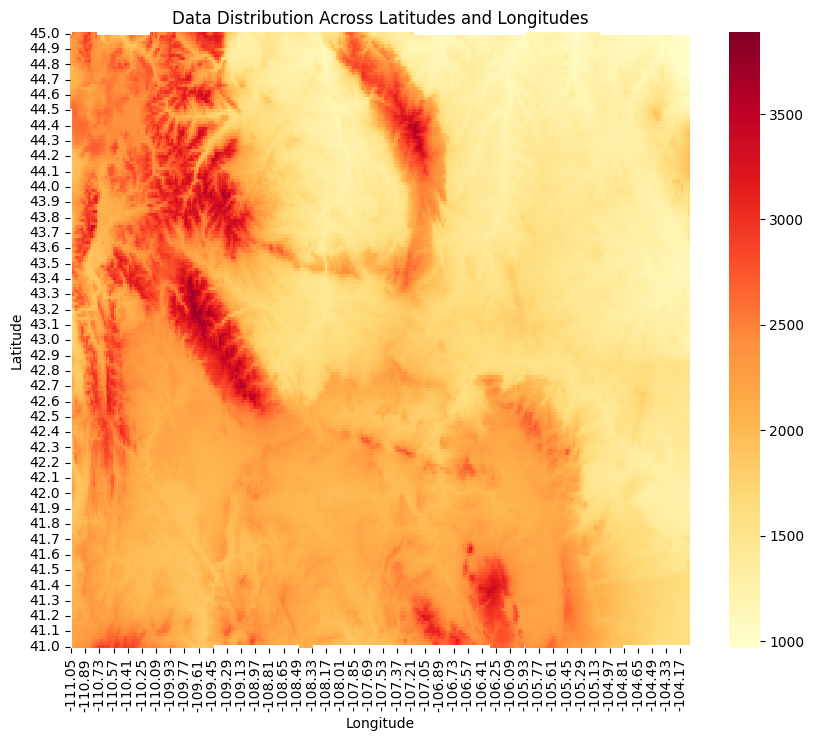

In [255]:
nsrdb_data_filtered
df_elevation = pd.DataFrame({
    'latitude': nsrdb_data_filtered['latitude'],
    'longitude': nsrdb_data_filtered['longitude'],
    'elevation': nsrdb_data_filtered['elevation'],
})
result_elevation = df_elevation.pivot_table(index='latitude', columns='longitude', values='elevation')
result_elevation = result_elevation.sort_index(ascending=False)
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(result_elevation, cmap='YlOrRd', fmt='g')
  
plt.title('Data Distribution Across Latitudes and Longitudes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [236]:
# sort result based on latitude descending
result = result.sort_index(ascending=False)


In [222]:
data_list = result.values.tolist()

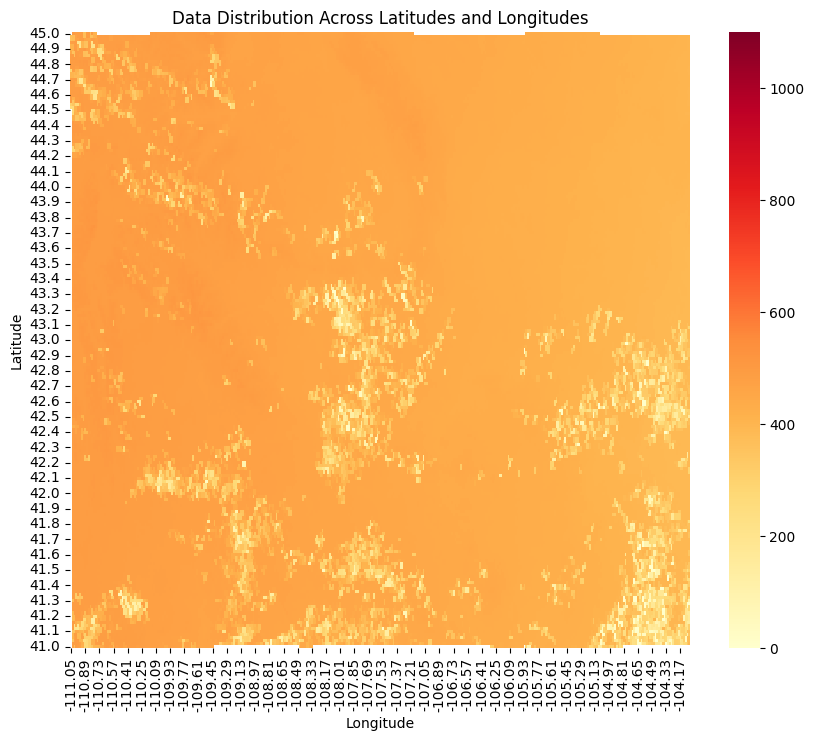

In [237]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(result, cmap='YlOrRd', fmt='g', vmin=0, vmax=1100)
  
plt.title('Data Distribution Across Latitudes and Longitudes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np


df = nsrdb_data_filtered

# Define the number of clusters
n_clusters = target_length

# Initialize and fit K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
df['cluster'] = kmeans.fit_predict(df[['latitude', 'longitude', 'elevation']])

# Aggregate data within each cluster
aggregated_df = df.groupby('cluster').agg({
    'latitude': 'mean',
    'longitude': 'mean',
    'elevation': 'mean',
    'ghi': ['mean', 'median', 'max'] 
}).reset_index()

# Flatten the columns (since aggregation creates a MultiIndex)
aggregated_df.columns = ['_'.join(col).strip() if type(col) is tuple else col for col in aggregated_df.columns.values]

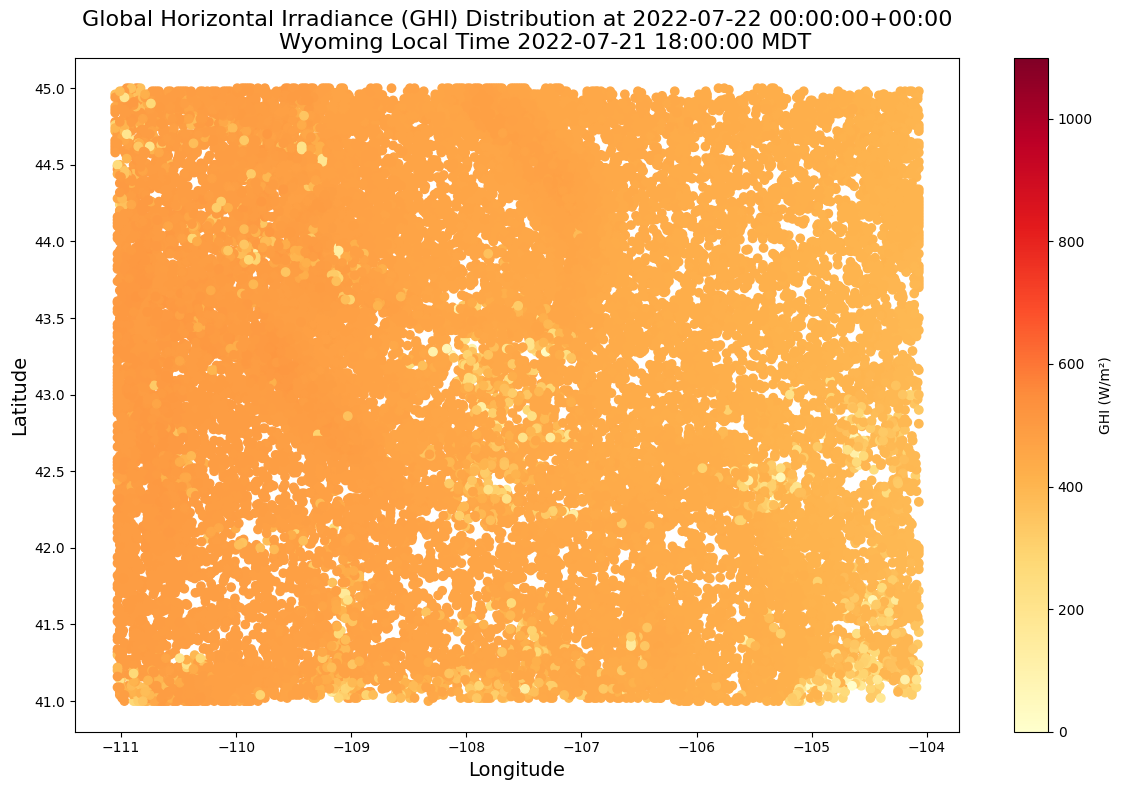

In [40]:
data = pd.read_csv(f'{nsrdb_goes_16}/nsrdb_goes_16_01.csv')

plt.figure(figsize=(12, 8))
colors = plt.get_cmap('YlOrRd')
sc = plt.scatter(
    aggregated_df["longitude_mean"],
    aggregated_df["latitude_mean"],
    c=aggregated_df["ghi_max"],
    cmap=colors,
    vmin=0,
    vmax=1100
)

date_time = pd.Timestamp(str(ds.time_bounds[0].data)[:19])
date_time = date_time.round('H').tz_localize('UTC')


wyoming_time = date_time.astimezone(wyoming_time_zone)
formatted_time = wyoming_time.strftime("%Y-%m-%d %H:%M:%S %Z")


plt.colorbar(sc, label="GHI (W/m²)")
plt.title(
    f"""Global Horizontal Irradiance (GHI) Distribution at {date_time}
        Wyoming Local Time {formatted_time}""",
    fontsize=16,
)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.tight_layout()
plt.savefig('wyo.png')
plt.show()


In [9]:
!pip freeze > requirements.txt